In [1]:
import keras
from src.ParticleNet.EdgeConvLayer import EdgeConvLayer
from src.ParticleNet.GlobalPooling import GlobalAveragePoolingLayer
from utilities import utilities
from ML.ParticleCloud.data_loaders import load_data_qg_tagging

#### Loading the Data

In [2]:
X_train, y_train = load_data_qg_tagging(quark_data_path="../../../Data/Trainning/q_jets.csv", gluon_data_path="../../../Data/Trainning/g_jets.csv")
X_val, y_val = load_data_qg_tagging(quark_data_path="../../../Data/Validation/q_jets.csv", gluon_data_path="../../../Data/Validation/g_jets.csv")

In [3]:
print(f"Size of the Training set: {len(X_train)}")
print(f"Size of the Validation set: {len(X_val)}")

Size of the Training set: 251379
Size of the Validation set: 44362


In [4]:
X_train.shape

(251379, 30, 5)

#### Setting up the NN

In [22]:
# MLP for the first conv layer
mlp_jets = keras.Sequential([
    keras.layers.InputLayer(shape=[8]),
    keras.layers.Dense(32),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(32),
    keras.layers.LeakyReLU()
])

# MLP for the second convolutional layer
jet_tag_model = keras.Sequential([
    keras.layers.InputLayer(shape=(30, 5)),
    EdgeConvLayer(mlp=mlp_jets, n_particles_features=4, mlp_output_dim=32, final_index_coord=2, max_number_particles=30, k_neighbors=4),
    GlobalAveragePoolingLayer(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(rate=0.1),
    keras.layers.Dense(2, activation='softmax')
])

jet_tag_model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ edge_conv_layer_6               │ (None, 30, 37)         │         1,344 │
│ (EdgeConvLayer)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer_4  │ (None, 36)             │             0 │
│ (GlobalAveragePoolingLayer)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 64)             │         2,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,842 (15.01 KB)

 Trainable params: 3,842 (15.01 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
jet_tag_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', "auc"])

In [24]:
early_stopping = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
history = jet_tag_model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])   

Epoch 1/100
3928/3928 ━━━━━━━━━━━━━━━━━━━━ 40s 10ms/step - accuracy: 0.7277 - auc: 0.7991 - loss: 0.5436 - val_accuracy: 0.7759 - val_auc: 0.8539 - val_loss: 0.4805
Epoch 2/100
3928/3928 ━━━━━━━━━━━━━━━━━━━━ 38s 10ms/step - accuracy: 0.7693 - auc: 0.8496 - loss: 0.4830 - val_accuracy: 0.7511 - val_auc: 0.8316 - val_loss: 0.5043
Epoch 3/100
3928/3928 ━━━━━━━━━━━━━━━━━━━━ 38s 10ms/step - accuracy: 0.7756 - auc: 0.8551 - loss: 0.4751 - val_accuracy: 0.7846 - val_auc: 0.8634 - val_loss: 0.4643
Epoch 4/100
3928/3928 ━━━━━━━━━━━━━━━━━━━━ 37s 9ms/step - accuracy: 0.7785 - auc: 0.8581 - loss: 0.4711 - val_accuracy: 0.7813 - val_auc: 0.8623 - val_loss: 0.4652
Epoch 5/100
3928/3928 ━━━━━━━━━━━━━━━━━━━━ 39s 10ms/step - accuracy: 0.7786 - auc: 0.8587 - loss: 0.4705 - val_accuracy: 0.7869 - val_auc: 0.8670 - val_loss: 0.4574
Epoch 6/100
3928/3928 ━━━━━━━━━━━━━━━━━━━━ 37s 9ms/step - accuracy: 0.7810 - auc: 0.8621 - loss: 0.4654 - val_accuracy: 0.7600 - val_auc: 0.8398 - val_loss: 0.4962
Epoch 7/100


In [25]:
# perfoming the prediction
y_train_pred = jet_tag_model.predict(X_train)
y_val_pred = jet_tag_model.predict(X_val)

7856/7856 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


In [26]:
print("Trainnig set:")
utilities.display_metrics(y_true=y_train[:, 0], y_pred=y_train_pred[:, 0] > 0.5)
print("Validation set:")
utilities.display_metrics(y_true=y_val[:, 0], y_pred=y_val_pred[:, 0] > 0.5)

Trainnig set:
Recall: 0.7605
Precision: 0.8321
Confusion Matrix:
[[109142  18922]
 [ 29531  93784]]
Validation set:
Recall: 0.7582
Precision: 0.8307
Confusion Matrix:
[[19238  3362]
 [ 5262 16500]]


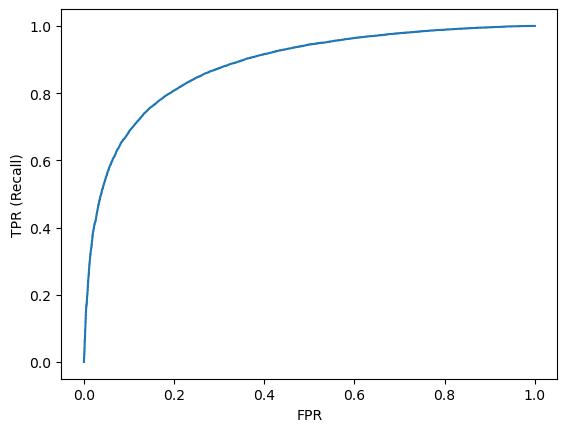

AUC: 0.8832


In [27]:
utilities.display_roc_curve(y_true=y_val[:, 0], y_score=y_val_pred[:, 0])

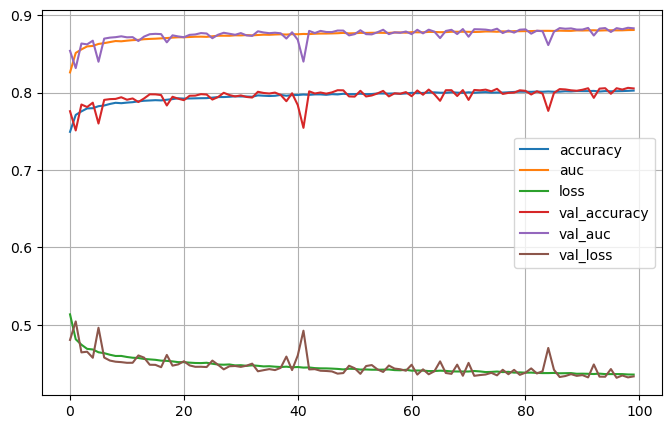

In [28]:
utilities.plot_hist_trainning(history)

In [29]:
utilities.save_model(jet_tag_model, history, "QuarkGluon_Tagging_ParticleCloud_Final")